In [1]:
%reset
import os

# Change the current working directory to the desired path
os.chdir('/mnt/home/spandey/ceph/GODMAX/src/')

# from get_BCMP_profile_jit import BCM_18_wP
# from get_KS_profile import KS_01
# from get_OBB_profile import OBB_nonconst
# from get_Battaglia_profile import Battaglia_12_16
import numpy as np
import jax.numpy as jnp
import colossus 
from jax import vmap, grad
%matplotlib inline
import matplotlib.pyplot as pl
pl.rc('text', usetex=False)
# Palatino
pl.rc('font', family='DejaVu Sans')

%load_ext autoreload
%autoreload 2




In [2]:
from colossus.cosmology import cosmology
cosmo_params_dict = {'flat': True, 'H0': 67.2, 'Om0': 0.31, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95, 'w0':-1.0}
cosmo = cosmology.setCosmology('myCosmo', **cosmo_params_dict)
sim_params_dict = {}
sim_params_dict['nfw_trunc'] = True
sim_params_dict['theta_co'] = 0.1
sim_params_dict['theta_ej'] = 4.0
sim_params_dict['neg_bhse_plus_1'] = 0.833
sim_params_dict['mu_beta'] = 0.21
sim_params_dict['eta_star'] = 0.3
sim_params_dict['eta_cga'] = 0.6
sim_params_dict['A_starcga'] = 0.09
sim_params_dict['M1_starcga'] = 2.5e11
sim_params_dict['epsilon_rt'] = 4.0
sim_params_dict['Mc0'] = 10**14.83
# sim_params_dict['Mc0'] = 10**1
sim_params_dict['nu_z'] = 0
sim_params_dict['nu_M'] = 0
sim_params_dict['Mstar0'] = 10**13
sim_params_dict['a_zeta'] = 0.3
sim_params_dict['n_zeta'] = 2
sim_params_dict['alpha_nt'] = 0.18
sim_params_dict['beta_nt'] = 0.5
sim_params_dict['n_nt'] = 0.8
sim_params_dict['cosmo'] = cosmo_params_dict
sim_params_dict['beam_fwhm_arcmin'] = 1.6



In [111]:
2**15

32768

In [146]:
halo_params_dict = {}
halo_params_dict['rmin'], halo_params_dict['rmax'], halo_params_dict['nr'] = 5e-3, 10, 64
halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.01, 2.5, 32
halo_params_dict['Mmin'], halo_params_dict['Mmax'], halo_params_dict['nM'] = 1e12, 1e15, 32
halo_params_dict['cmin'], halo_params_dict['cmax'], halo_params_dict['nc'] = 2, 10, 32
halo_params_dict['ellmin'], halo_params_dict['ellmax'], halo_params_dict['nell'] = 8, 2**16, 256
halo_params_dict['sig_logc_z_array'] = np.ones(halo_params_dict['nz']) * 0.25
halo_params_dict['mdef'] = '200c'




In [147]:
from astropy.io import fits
df = fits.open('/mnt/home/spandey/ceph/GODMAX/data/sim_3x2pt_simulated_DV_PKproject_values_bestfit_maglim_3x2LCDM_final.fits') 
z_array = df['nz_source'].data['Z_MID']
nz_info_dict = {}
nz_info_dict['z_array'] = z_array
nz_info_dict['nbins'] = 4
nz_info_dict['nz0'] = np.maximum(df['nz_source'].data['BIN1'], 1e-3)
nz_info_dict['nz1'] = np.maximum(df['nz_source'].data['BIN2'], 1e-3)
nz_info_dict['nz2'] = np.maximum(df['nz_source'].data['BIN3'], 1e-3)
nz_info_dict['nz3'] = np.maximum(df['nz_source'].data['BIN4'], 1e-3)
analysis_dict = {}
analysis_dict['nz_info_dict'] = nz_info_dict
analysis_dict['do_sheary'] = True
analysis_dict['do_shear2pt'] = True

df_data = fits.open('/mnt/home/spandey/ceph/GODMAX/data/DES_ACT_full_data_theorycov_2.5.fits')
theta_data = df_data['compton_shear'].data['ANG'][0:20]


analysis_dict['angles_data_array'] = jnp.array(theta_data)



In [148]:
# from jax_cosmo import Cosmology
# from jax_cosmo.power import linear_matter_power
# cosmo_jax = Cosmology(
#             Omega_c=cosmo_params_dict['Om0'] - cosmo_params_dict['Ob0'],
#             Omega_b=cosmo_params_dict['Ob0'],
#             h=cosmo_params_dict['H0'] / 100.,
#             sigma8=cosmo_params_dict['sigma8'],
#             n_s=cosmo_params_dict['ns'],
#             Omega_k=0.,
#             w0=cosmo_params_dict['w0'],
#             wa=0.
#             )
# z_array = jnp.linspace(0, 1, 10)
# a_array = 1./(1. + z_array)
# k_array = jnp.logspace(-3, 1, 100)
# pkz = vmap(linear_matter_power,(None, None, 0))(cosmo_jax, k_array, a_array)



In [149]:
# # pkz.shape
# pl.figure()
# pl.plot(k_array, pkz[0,:])
# pl.plot(k_array, pkz[5,:])
# pl.xscale('log')
# pl.yscale('log')


In [150]:
# %%time
# BCMP_test = BCM_18_wP(sim_params_dict, halo_params_dict)

from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)


gpu


In [151]:
from setup_power_spectra import setup_power_BCMP



In [152]:
%%time
setup_power_BCMP_test = setup_power_BCMP(sim_params_dict, halo_params_dict, num_points_trapz_int=64)




CPU times: user 15.7 s, sys: 360 ms, total: 16.1 s
Wall time: 19.9 s


In [153]:
from get_power_spectra import get_power_BCMP

# get_power_BCMP_test = get_power_BCMP(sim_params_dict, halo_params_dict, setup_power_BCMP_test, num_points_trapz_int=64)
get_power_BCMP_obj_test = get_power_BCMP(sim_params_dict, halo_params_dict, analysis_dict,setup_power_BCMP_obj=setup_power_BCMP_test, verbose_time=True)



Time for setup_power_BCMP:  2.384185791015625e-07
Time for computing Wk_mat:  0.3099043369293213
Time for computing p_logc_Mz:  0.6269268989562988
Time for computing Cl_kappa_y_1h_mat:  0.9591209888458252
Time for computing Cl_kappa_y_2h_mat:  0.07641386985778809
Time for computing Cl_kappa_kappa_1h_mat:  0.5513026714324951
Time for computing Cl_kappa_kappa_2h_mat:  0.08325314521789551
Time for computing Cl_kappa_kappa_nfw_1h_mat:  0.5309805870056152
Total time for computing all Cls:  3.210280656814575


In [154]:
from get_corr_func import get_corrfunc_BCMP
get_corrfunc_BCMP_test = get_corrfunc_BCMP(sim_params_dict, halo_params_dict, analysis_dict, get_power_BCMP_obj=get_power_BCMP_obj_test, verbose_time=True)



Time for setup_power_BCMP:  4.76837158203125e-07
Time for gty Hankel transform:  0.2043933868408203
Time for xip Hankel transform:  0.13652968406677246
Time for xim Hankel transform:  0.13605880737304688


(0.0, 2e-09)

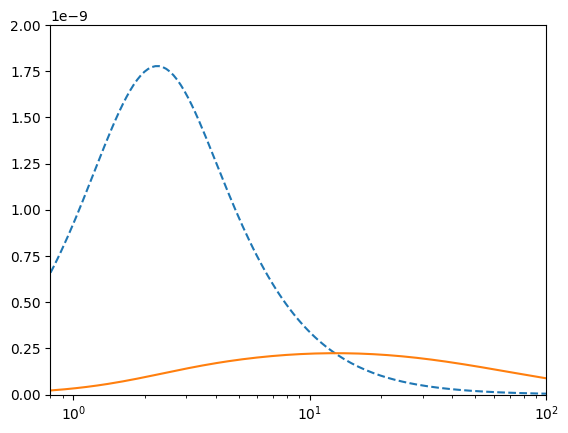

In [155]:
# get_power_BCMP_test.p_logc_Mz.shape
pl.figure()
pl.plot(get_corrfunc_BCMP_test.theta_out_arcmin, get_corrfunc_BCMP_test.gty_1h_mat[3,:], ls='--')
pl.plot(get_corrfunc_BCMP_test.theta_out_arcmin, get_corrfunc_BCMP_test.gty_2h_mat[3,:], ls='-')
pl.xscale('log')
pl.xlim(0.8,100)
pl.ylim(0.0,2e-9)
# pl.yscale('log')




(0.0, 0.0002)

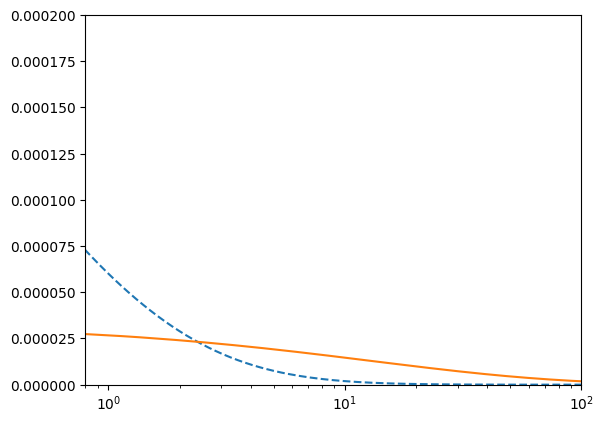

In [170]:
# get_power_BCMP_test.p_logc_Mz.shape
pl.figure()
pl.plot(get_corrfunc_BCMP_test.theta_out_arcmin, get_corrfunc_BCMP_test.xip_1h_mat[3,3,:], ls='--')
pl.plot(get_corrfunc_BCMP_test.theta_out_arcmin, get_corrfunc_BCMP_test.xip_2h_mat[3,3,:], ls='-')
pl.xscale('log')
pl.xlim(0.8,100)
pl.ylim(0.0,2e-4)
# pl.yscale('log')




In [157]:
# get_corrfunc_BCMP_test.theta_out_arcmin

(0.0, 2e-05)

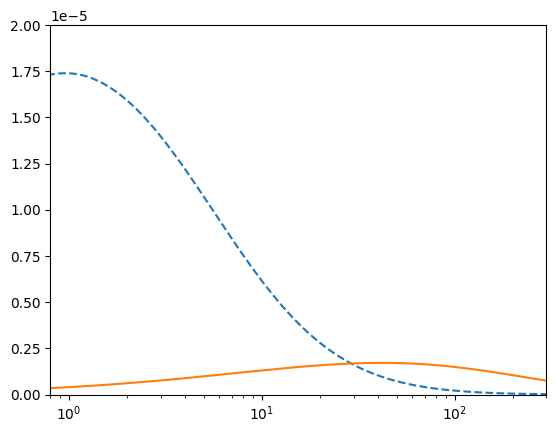

In [169]:
# get_power_BCMP_test.p_logc_Mz.shape
pl.figure()
pl.plot(get_corrfunc_BCMP_test.theta_out_arcmin, get_corrfunc_BCMP_test.xim_1h_mat[3,3,:], ls='--')
pl.plot(get_corrfunc_BCMP_test.theta_out_arcmin, get_corrfunc_BCMP_test.xim_2h_mat[3,3,:], ls='-')
pl.xscale('log')
pl.xlim(0.8,300)
pl.ylim(0.0,2e-5)
# pl.yscale('log')




In [159]:
# check if all the elements are finite
np.all(np.isfinite(setup_power_BCMP_test.uk_dmb)), np.all(np.isfinite(setup_power_BCMP_test.uk_nfw))


(True, True)

In [160]:
# check if all the elements are finite
# np.all(np.isfinite(setup_power_BCMP_test.uyl_mat))
get_power_BCMP_obj_test.Cl_kappa_y_1h_mat


Array([[1.04249139e-14, 1.03850134e-14, 1.03523871e-14, ...,
        1.48067284e-51, 6.23525681e-54, 1.74656205e-56],
       [1.26214004e-14, 1.25804670e-14, 1.25469960e-14, ...,
        1.98013196e-51, 8.31044676e-54, 2.32827807e-56],
       [1.55397613e-14, 1.54988796e-14, 1.54654507e-14, ...,
        2.71558940e-51, 1.13519682e-53, 3.17766076e-56],
       [1.86681803e-14, 1.86267260e-14, 1.85928287e-14, ...,
        7.47040155e-51, 3.12059902e-53, 8.78744389e-56]], dtype=float64)

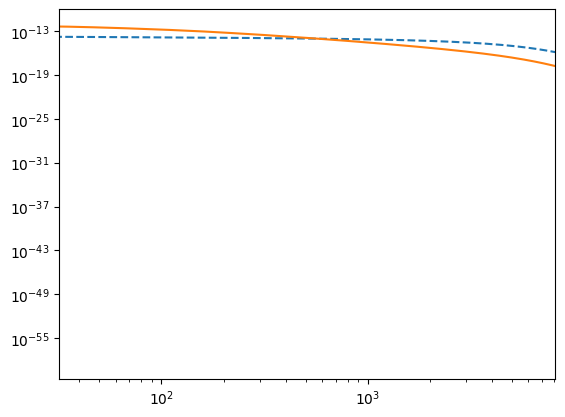

In [161]:
pl.figure()
pl.plot(get_power_BCMP_obj_test.ell_array, get_power_BCMP_obj_test.Cl_kappa_y_1h_mat[3,:], ls='--')
pl.plot(get_power_BCMP_obj_test.ell_array, get_power_BCMP_obj_test.Cl_kappa_y_2h_mat[3,:], ls='-')
pl.xlim(32, 8096)
# pl.ylim(1e-19, 5e-13)
# pl.plot(get_power_BCMP_test.ell_array, (get_power_BCMP_test.ell_array**3) * (get_power_BCMP_test.Cl_kappa_y_1h_mat[3,:] + get_power_BCMP_test.Cl_kappa_y_2h_mat[3,:]), ls='-') 
pl.xscale('log')
pl.yscale('log')




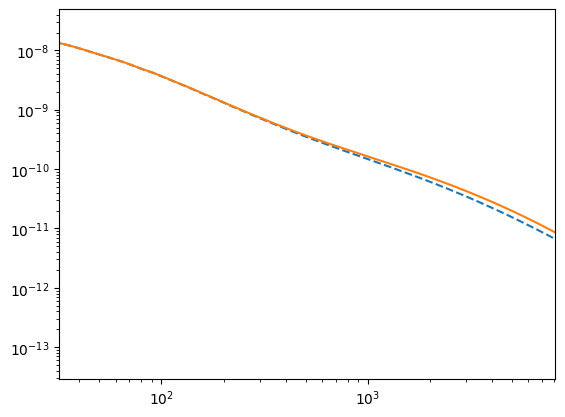

In [162]:
pl.figure()
pl.plot(get_power_BCMP_obj_test.ell_array, get_power_BCMP_obj_test.Cl_kappa_kappa_1h_mat[3,3,:] + get_power_BCMP_obj_test.Cl_kappa_kappa_2h_mat[3,3,:], ls='--')
pl.plot(get_power_BCMP_obj_test.ell_array, get_power_BCMP_obj_test.Cl_kappa_kappa_nfw_1h_mat[3,3,:] + get_power_BCMP_obj_test.Cl_kappa_kappa_2h_mat[3,3,:], ls='-')
pl.xlim(32, 8096)
# pl.ylim(1e-19, 5e-13)
# pl.plot(get_power_BCMP_test.ell_array, (get_power_BCMP_test.ell_array**3) * (get_power_BCMP_test.Cl_kappa_y_1h_mat[3,:] + get_power_BCMP_test.Cl_kappa_y_2h_mat[3,:]), ls='-') 
pl.xscale('log')
pl.yscale('log')




In [163]:
C = jnp.array(df_data['COVMAT'].data[400:,400:])
data_vec = jnp.array(df_data['compton_shear'].data['VALUE'])
gty_data_to_plot = data_vec[60:]
gty_sig_to_plot = jnp.sqrt(jnp.diag(C))[60:]



In [164]:
C = jnp.array(df_data['COVMAT'].data[:200,:200])
data_vec = jnp.array(df_data['xip'].data['VALUE'])
bin1, bin2 = df_data['xip'].data['BIN1'], df_data['xip'].data['BIN2']
indsel = np.where((bin1==4) & (bin2==4))[0]
xip_data_to_plot = data_vec[indsel]
xip_sig_to_plot = jnp.sqrt(jnp.diag(C))[indsel]



In [165]:
C = jnp.array(df_data['COVMAT'].data[200:400,200:400])
data_vec = jnp.array(df_data['xim'].data['VALUE'])
bin1, bin2 = df_data['xim'].data['BIN1'], df_data['xim'].data['BIN2']
indsel = np.where((bin1==4) & (bin2==4))[0]
xim_data_to_plot = data_vec[indsel]
xim_sig_to_plot = jnp.sqrt(jnp.diag(C))[indsel]



Text(0.5, 0, '$\\theta$ (arcmin)')

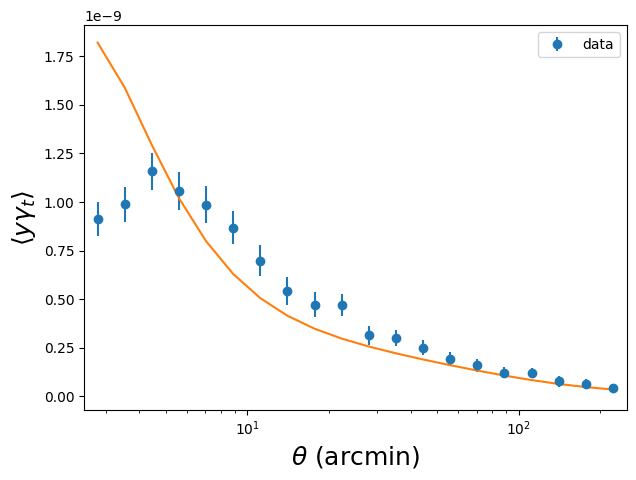

In [166]:
pl.figure(figsize=(7,5))
# pl.subplot(131)
pl.errorbar(analysis_dict['angles_data_array'], gty_data_to_plot, yerr=gty_sig_to_plot, fmt='o', label='data')
# for jt in range(len(theta_ej_all)):
pl.plot(analysis_dict['angles_data_array'], get_corrfunc_BCMP_test.gty_out_mat[3,:])
pl.legend()
pl.xscale('log')
pl.xlim(2.5,250)
# pl.ylim(0.0,2e-9)
# pl.title(r'Variation of $\theta_{ej}$')
pl.ylabel(r'$\langle y \gamma_t \rangle$', size=18)
pl.xlabel(r'$\theta$ (arcmin)', size=18)


In [167]:
get_corrfunc_BCMP_test.xip_out_mat.shape

(20, 4, 4)

Text(0.5, 0, '$\\theta$ (arcmin)')

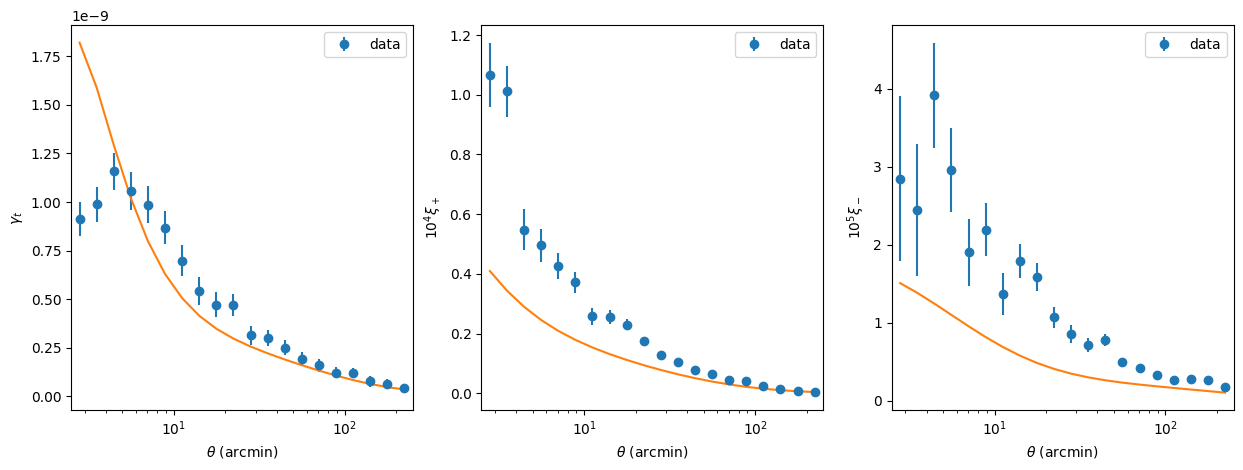

In [168]:
# make a three panel plot, plotting all the theta_ej curves for for gty_out_thetaej[:,3,:], xip_out_thetaej[:,3,3,:], xim_out_thetaej[:,3,3,:]
# draw theta_ej curves from a colormap

pl.figure(figsize=(15,5))
pl.subplot(131)
pl.errorbar(analysis_dict['angles_data_array'], gty_data_to_plot, yerr=gty_sig_to_plot, fmt='o', label='data')
pl.plot(analysis_dict['angles_data_array'], get_corrfunc_BCMP_test.gty_out_mat[3,:])
pl.legend()
pl.xscale('log')
pl.xlim(2.5,250)
# pl.ylim(0.0,2e-9)
pl.ylabel(r'$\gamma_t$')
pl.xlabel(r'$\theta$ (arcmin)')
# pl.title('1-halo term')
pl.subplot(132)
pl.errorbar(analysis_dict['angles_data_array'], 1e4*xip_data_to_plot, yerr=1e4*xip_sig_to_plot, fmt='o', label='data')
pl.plot(analysis_dict['angles_data_array'], 1e4*get_corrfunc_BCMP_test.xip_out_mat.T[3,3,:])
pl.legend()
pl.xscale('log')
pl.xlim(2.5,250)
# pl.ylim(0.0,2e-9)
pl.ylabel(r'$10^4 \xi_+$')
pl.xlabel(r'$\theta$ (arcmin)')
# pl.title('2-halo term')
pl.subplot(133)
pl.errorbar(analysis_dict['angles_data_array'], 1e5*xim_data_to_plot, yerr=1e5*xim_sig_to_plot, fmt='o', label='data')
pl.plot(analysis_dict['angles_data_array'], 1e5*get_corrfunc_BCMP_test.xim_out_mat.T[3,3,:])
pl.legend()
pl.legend()
pl.xscale('log')
pl.xlim(2.5,250)
# pl.ylim(0.0,2e-9)
pl.ylabel(r'$10^5 \xi_-$')
pl.xlabel(r'$\theta$ (arcmin)')
# pl.title('2-halo term')






In [138]:
analysis_dict['angles_data_array']

Array([  2.80504614,   3.53134386,   4.44569853,   5.59680285,
         7.04595733,   8.87033473,  11.1670898 ,  14.05853313,
        17.69864461,  22.28127345,  28.05046136,  35.31343862,
        44.45698525,  55.96802846,  70.45957328,  88.70334731,
       111.67089804, 140.5853313 , 176.9864461 , 222.81273453],      dtype=float64)

In [52]:
# from colossus.lss import bias
# bM = bias.haloBias(setup_power_BCMP_test.M_array, 0.0, mdef='200c', model='tinker10')

# # dndm_jax.shape
# pl.figure()
# pl.plot(setup_power_BCMP_test.M_array, setup_power_BCMP_test.bias_Mz_mat[0,:])
# pl.plot(setup_power_BCMP_test.M_array, bM, ls='--')
# pl.xscale('log')
# # pl.yscale('log')





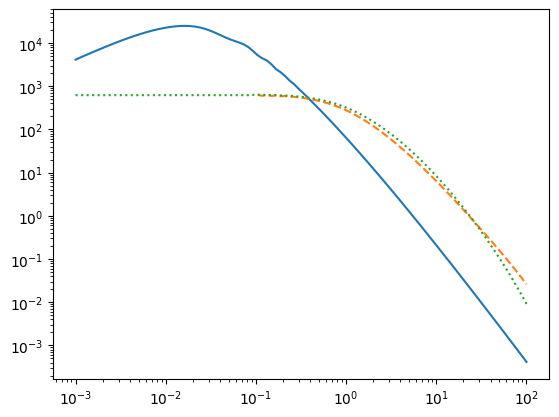

In [71]:
pl.figure()
pl.plot(setup_power_BCMP_test.kPk_array, setup_power_BCMP_test.plin_kz_mat[:,0])
pl.plot(setup_power_BCMP_test.kPk_array, setup_power_BCMP_test.Pmm_dmb_1h_mat[:,0], ls='--')
pl.plot(setup_power_BCMP_test.kPk_array, setup_power_BCMP_test.Pmm_nfw_1h_mat[:,0], ls=':')
pl.xscale('log')
pl.yscale('log')



(0.69, 1.5)

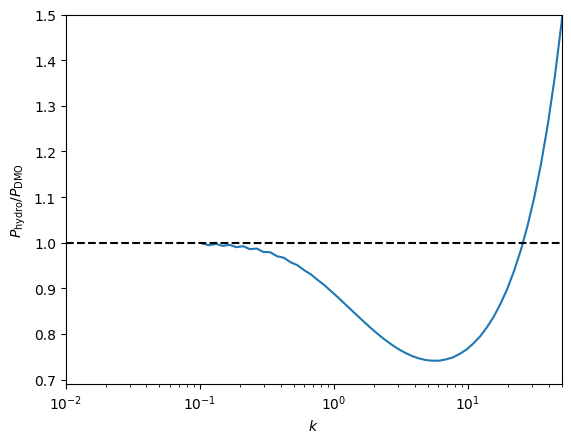

In [72]:
Pk_nfw = setup_power_BCMP_test.plin_kz_mat[:,0] + setup_power_BCMP_test.Pmm_nfw_1h_mat[:,0]
Pk_dmb = setup_power_BCMP_test.plin_kz_mat[:,0] + setup_power_BCMP_test.Pmm_dmb_1h_mat[:,0]
pl.figure()
pl.plot(setup_power_BCMP_test.kPk_array, (Pk_dmb)/Pk_nfw)
pl.xscale('log')
pl.axhline(1.0, color='k', ls='--')
pl.xlim(1e-2, 50)
pl.xlabel(r'$k$')
pl.ylabel(r'$P_{\rm hydro}/P_{\rm DMO}$')
pl.ylim(0.69,1.5)
# pl.yscale('log')




In [157]:
# setup_power_BCMP_test.Pmm_dmb_1h_mat.shape
# setup_power_BCMP_test.kPk_array
# setup_power_BCMP_test.uk_nfw_Pk[:,0,0,0]
# setup_power_BCMP_test.uk_dmb_Pk[:,0,0,0]
setup_power_BCMP_test.uk_dmb[:,0,0,0]
# (Pk_dmb)
# Pk_nfw

Array([-4.00917588e+01,  3.15555364e+01, -2.16192225e+01,  1.77459096e+01,
       -1.13110086e+01,  1.00646361e+01, -5.59863161e+00,  5.82615607e+00,
       -2.46205120e+00,  3.51198095e+00, -7.60692354e-01,  2.26615259e+00,
        1.47099797e-01,  1.60821567e+00,  6.20517368e-01,  1.26999674e+00,
        8.59309159e-01,  1.10289208e+00,  9.73576649e-01,  1.02530177e+00,
        1.02326095e+00,  9.92894412e-01,  1.04037961e+00,  9.81820950e-01,
        1.04144753e+00,  9.79233196e-01,  1.03430317e+00,  9.77881133e-01,
        1.02173048e+00,  9.72954473e-01,  1.00324800e+00,  9.60173240e-01,
        9.75929867e-01,  9.34720194e-01,  9.34983657e-01,  8.91115466e-01,
        8.74892490e-01,  8.24497564e-01,  7.91847864e-01,  7.33499282e-01,
        6.87197189e-01,  6.23330663e-01,  5.69473224e-01,  5.05703063e-01,
        4.51729914e-01,  3.93745303e-01,  3.45207093e-01,  2.96172389e-01,
        2.55588807e-01,  2.16272309e-01,  1.84131210e-01,  1.53955105e-01,
        1.29576529e-01,  

In [156]:
setup_power_BCMP_test.k

Array([8.54534660e-03, 1.00000000e-02, 1.17022755e-02, 1.36943251e-02,
       1.60254765e-02, 1.87534541e-02, 2.19458086e-02, 2.56815898e-02,
       3.00533038e-02, 3.51692040e-02, 4.11559714e-02, 4.81618515e-02,
       5.63603253e-02, 6.59544053e-02, 7.71816620e-02, 9.03201070e-02,
       1.05695077e-01, 1.23687291e-01, 1.44742275e-01, 1.69381398e-01,
       1.98214778e-01, 2.31956394e-01, 2.71441762e-01, 3.17648627e-01,
       3.71721174e-01, 4.34998358e-01, 5.09047061e-01, 5.95700894e-01,
       6.97105597e-01, 8.15772173e-01, 9.54639070e-01, 1.11714494e+00,
       1.30731378e+00, 1.52985460e+00, 1.79027800e+00, 2.09503263e+00,
       2.45166490e+00, 2.86900580e+00, 3.35738962e+00, 3.92890982e+00,
       4.59771851e+00, 5.38037685e+00, 6.29626521e+00, 7.36806300e+00,
       8.62231029e+00, 1.00900650e+01, 1.18076721e+01, 1.38176631e+01,
       1.61698100e+01, 1.89223571e+01, 2.21434636e+01, 2.59128911e+01,
       3.03239790e+01, 3.54859556e+01, 4.15266428e+01, 4.85956213e+01,
      

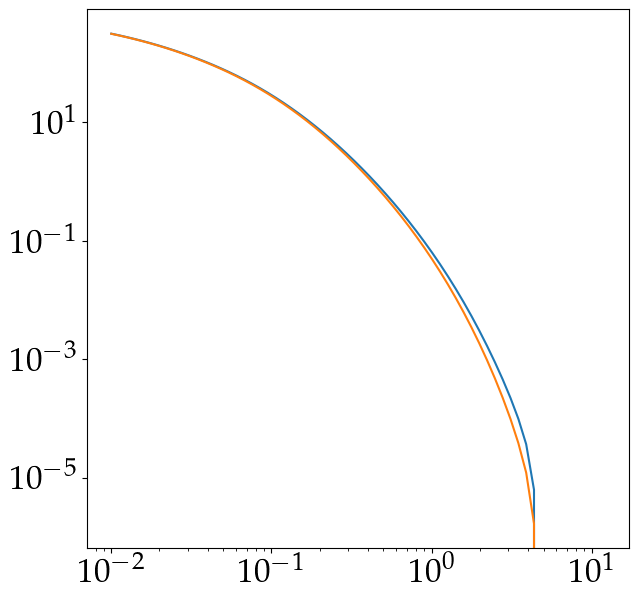

In [63]:
# Ptot_mat.shape
import matplotlib.pyplot as pl
import matplotlib
%matplotlib inline

pl.figure()
pl.plot(BCMP_test.r_array, BCMP_test.Ptot_mat[:,0,0,0])
pl.plot(BCMP_test.r_array, BCMP_test.Pth_mat[:,0,0,0])
pl.xscale('log')
pl.yscale('log')
pl.show()




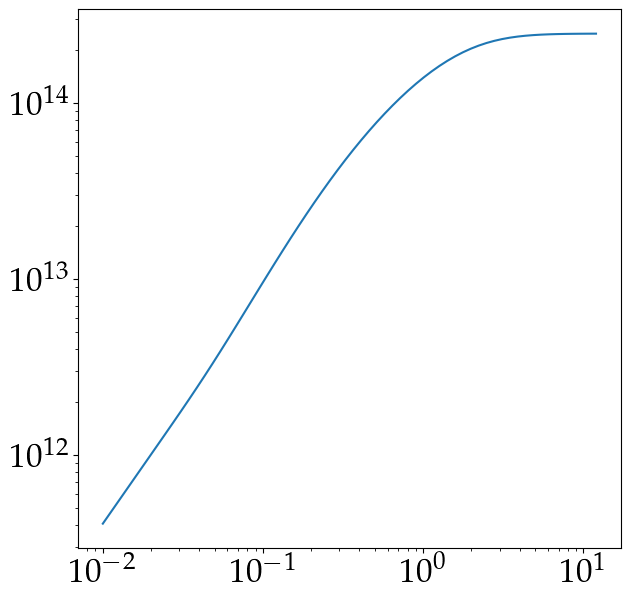

In [64]:
# Ptot_mat.shape
import matplotlib.pyplot as pl
import matplotlib
%matplotlib inline

pl.figure()
pl.plot(BCMP_test.r_array, BCMP_test.Mdmb_mat[:,0,0,0])
# pl.plot(BCMP_test.r_array, BCMP_test.Pth_mat[:,0,0,0])
pl.xscale('log')
pl.yscale('log')
pl.show()




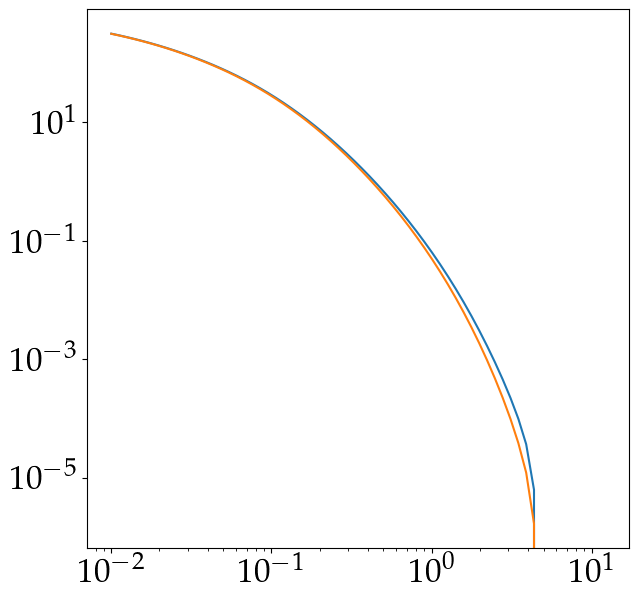

In [65]:
# Ptot_mat.shape
import matplotlib.pyplot as pl
import matplotlib
%matplotlib inline

pl.figure()
pl.plot(BCMP_test.r_array, BCMP_test.Ptot_mat[:,0,0,0])
pl.plot(BCMP_test.r_array, BCMP_test.Pth_mat[:,0,0,0])
pl.xscale('log')
pl.yscale('log')
pl.show()




In [66]:
%%time
vmap_func1 = vmap(BCMP_test.get_rho_gas_normed, (0, None, None, None))
vmap_func2 = vmap(vmap_func1, (None, 0, None, None))
vmap_func3 = vmap(vmap_func2, (None, None, 0, None))
vmap_func4 = vmap(vmap_func3, (None, None, None, 0))
rho_gas_normed_mat = vmap_func4(jnp.arange(len(BCMP_test.r_array)), jnp.arange(len(BCMP_test.conc_array)), jnp.arange(len(BCMP_test.z_array)), jnp.arange(len(BCMP_test.M200c_array))).T



CPU times: user 222 ms, sys: 0 ns, total: 222 ms
Wall time: 171 ms


In [67]:
%%time
vmap_func1 = vmap(BCMP_test.get_rho_clm, (0, None, None, None))
vmap_func2 = vmap(vmap_func1, (None, 0, None, None))
vmap_func3 = vmap(vmap_func2, (None, None, 0, None))
vmap_func4 = vmap(vmap_func3, (None, None, None, 0))
rho_clm_normed_mat = vmap_func4(jnp.arange(len(BCMP_test.r_array)), jnp.arange(len(BCMP_test.conc_array)), jnp.arange(len(BCMP_test.z_array)), jnp.arange(len(BCMP_test.M200c_array))).T



CPU times: user 759 ms, sys: 16.4 ms, total: 775 ms
Wall time: 422 ms


In [68]:
%%time
vmap_func1 = vmap(BCMP_test.get_rho_cga, (0, None, None, None))
vmap_func2 = vmap(vmap_func1, (None, 0, None, None))
vmap_func3 = vmap(vmap_func2, (None, None, 0, None))
vmap_func4 = vmap(vmap_func3, (None, None, None, 0))
rho_cga_normed_mat = vmap_func4(jnp.arange(len(BCMP_test.r_array)), jnp.arange(len(BCMP_test.conc_array)), jnp.arange(len(BCMP_test.z_array)), jnp.arange(len(BCMP_test.M200c_array))).T



CPU times: user 236 ms, sys: 0 ns, total: 236 ms
Wall time: 153 ms


In [69]:
%%time
vmap_func1 = vmap(BCMP_test.get_rho_dmb, (0, None, None, None))
vmap_func2 = vmap(vmap_func1, (None, 0, None, None))
vmap_func3 = vmap(vmap_func2, (None, None, 0, None))
vmap_func4 = vmap(vmap_func3, (None, None, None, 0))
rho_dmb_normed_mat = vmap_func4(jnp.arange(len(BCMP_test.r_array)), jnp.arange(len(BCMP_test.conc_array)), jnp.arange(len(BCMP_test.z_array)), jnp.arange(len(BCMP_test.M200c_array))).T



CPU times: user 922 ms, sys: 36.1 ms, total: 959 ms
Wall time: 543 ms


In [94]:
%%time
vmap_func1 = vmap(BCMP_test.get_rho_nfw_normed, (0, None, None, None))
vmap_func2 = vmap(vmap_func1, (None, 0, None, None))
vmap_func3 = vmap(vmap_func2, (None, None, 0, None))
vmap_func4 = vmap(vmap_func3, (None, None, None, 0))
rho_nfw_normed_mat = vmap_func4(jnp.arange(len(BCMP_test.r_array)), jnp.arange(len(BCMP_test.conc_array)), jnp.arange(len(BCMP_test.z_array)), jnp.arange(len(BCMP_test.M200c_array))).T



CPU times: user 153 ms, sys: 4.86 ms, total: 158 ms
Wall time: 196 ms


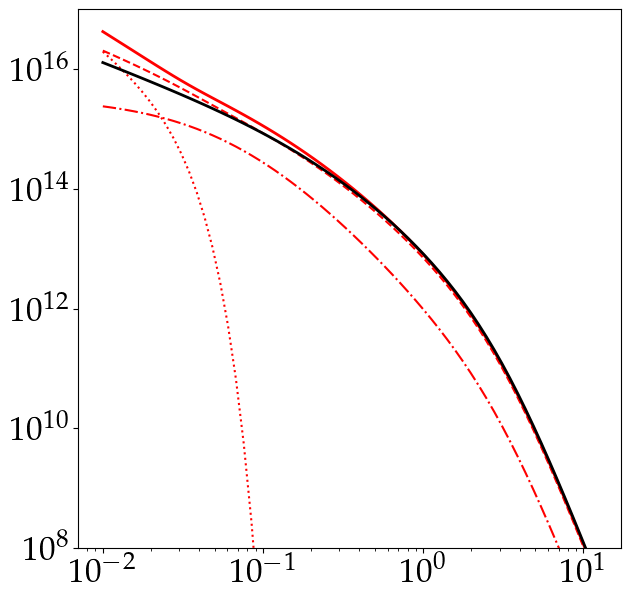

In [71]:
pl.figure()
pl.plot(BCMP_test.r_array, rho_gas_normed_mat[:,0,0,0], ls='-.', color='r')
pl.plot(BCMP_test.r_array, rho_clm_normed_mat[:,0,0,0], ls='--', color='r')
pl.plot(BCMP_test.r_array, rho_cga_normed_mat[:,0,0,0], ls=':', color='r')
pl.plot(BCMP_test.r_array, rho_dmb_normed_mat[:,0,0,0], ls='-', color='r', lw=2)
pl.plot(BCMP_test.r_array, rho_nfw_normed_mat[:,0,0,0], ls='-', color='k', lw=2)
pl.xscale('log')
pl.yscale('log')
pl.ylim(1e8, 1e17)
pl.show()






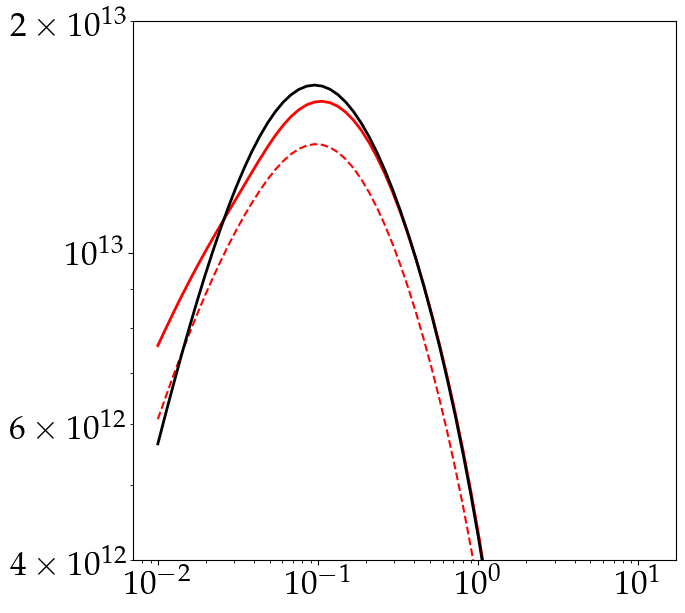

In [77]:
pl.figure()
pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*rho_gas_normed_mat[:,-5,0,0], ls='-.', color='r')
pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*rho_clm_normed_mat[:,-5,0,0], ls='--', color='r')
pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*rho_cga_normed_mat[:,-5,0,0], ls=':', color='r')
pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*rho_dmb_normed_mat[:,-5,0,0], ls='-', color='r', lw=2)
pl.plot(BCMP_test.r_array, (BCMP_test.r_array**2)*rho_nfw_normed_mat[:,-5,0,0], ls='-', color='k', lw=2)
pl.xscale('log')
pl.yscale('log')
pl.ylim(4e12,2e13)
# pl.ylim(1e8, 1e17)
pl.show()






In [91]:
# BCMP_test.conc_array[-5]
from mcfit import xi2P


In [104]:
Mtot_rep = jnp.repeat(BCMP_test.Mtot_mat[None, :, :, :], len(BCMP_test.r_array), axis=0)


In [103]:
BCMP_test.Mtot_mat.shape


(16, 64, 64)

In [109]:
k, P_nfw = xi2P(BCMP_test.r_array)(BCMP_test.rho_nfw_mat/Mnfw_rep, axis=0)



In [108]:
k, P_dmb = xi2P(BCMP_test.r_array)(BCMP_test.rho_dmb_mat/Mnfw_rep, axis=0)



In [128]:
window = jnp.ones(5) / 5
y_smooth = jnp.convolve(P_nfw[:,-5,0,0], window, mode='same')



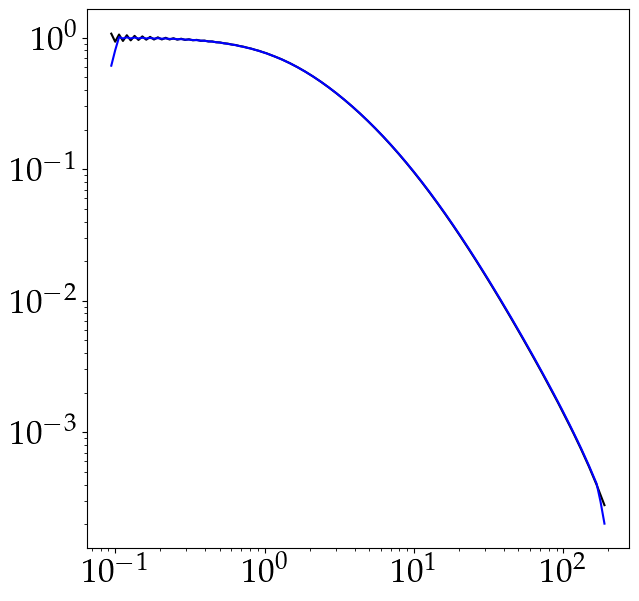

In [131]:
pl.figure()
indc = 3
window = jnp.ones(5) / 5
# pl.plot(k, (k**3) * P_nfw[:,indc,0,0], color='k')
# pl.plot(k, (k**3) * jnp.convolve(P_nfw[:,indc,0,0], window, mode='same'), color='b')
pl.plot(k, P_nfw[:,indc,0,0], color='k')
pl.plot(k, jnp.convolve(P_nfw[:,indc,0,0], window, mode='same'), color='b')

pl.xscale('log')
pl.yscale('log')




In [ ]:
from jax_cosmo.power import sigmasqr

